In [1]:
import sys
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
import neural_rock.preprocess as pre
from neural_rock.dataset import ThinSectionDataset
from neural_rock.training import train, validate
from neural_rock.utils import set_seed, save_checkpoint, create_run_directory, get_lr

In [2]:
validate_every = 50
use_weighted_loss = True
test_size = 0.5
random_state = 42
num_workers = 4
batch_size = 32
learning_rate = 1e-3
weight_decay = 1e-4
momentum = 0.9
max_steps = 5000
target_feature = 'Dunham'

In [3]:
set_seed(random_state, cudnn=True, benchmark=True)

path = create_run_directory("./runs", prefix=target_feature)

train_step_writer = SummaryWriter(log_dir=os.path.join(path, "tensorboard", "train"))
val_step_writer = SummaryWriter(log_dir=os.path.join(path, "tensorboard", "val"))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
df = pre.load_excel()

imgs, features, df_ = pre.load_images_w_rows_in_table(df)
imgs = np.array(imgs)

if target_feature == 'Dunham':
    pore_type, modified_label_map, class_names = pre.make_feature_map_dunham(features)
elif target_feature == 'Lucia':
    pore_type, modified_label_map, class_names = pre.make_feature_map_lucia(features)
elif target_feature == 'MicroPorosity':
    pore_type, modified_label_map, class_names = pre.make_feature_map_microp(features)

pore_type = np.array(pore_type)

splitter = StratifiedShuffleSplit(test_size=test_size, random_state=random_state)

for train_idx, val_idx in splitter.split(imgs, pore_type):
    print(train_idx, val_idx)
    break

imgs_train, pore_type_train = imgs[train_idx], pore_type[train_idx]
imgs_val, pore_type_val = imgs[val_idx], pore_type[val_idx]

print("train", np.unique(pore_type_train, return_counts=True))
print("val", np.unique(pore_type_val, return_counts=True))

39it [00:01, 20.02it/s]


['B' 'FL' 'G' 'G-P' 'P' 'P-G' 'rDol']
(array([0, 1, 2, 3, 4, 5]), array([14,  5,  3,  8,  3,  6]))
[30 27 20 21 23 38 17 35 37 29 14 12  6  2 31 34  9  5  4] [33  0 13  8 32  3  7 28 16 11 15 26  1 18 24 36 25 10 22 19]
train (array([0, 1, 2, 3, 4, 5]), array([7, 2, 1, 4, 2, 3]))
val (array([0, 1, 2, 3, 4, 5]), array([7, 3, 2, 4, 1, 3]))


In [5]:
del imgs

In [6]:
X_train_np, y_train_np = pre.create_images_and_labels(imgs_train, pore_type_train)
X_val_np, y_val_np = pre.create_images_and_labels(imgs_val, pore_type_val)

X_train_np = X_train_np.astype(np.uint8)
X_val_np = X_val_np.astype(np.uint8)

del imgs_train
del imgs_val

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

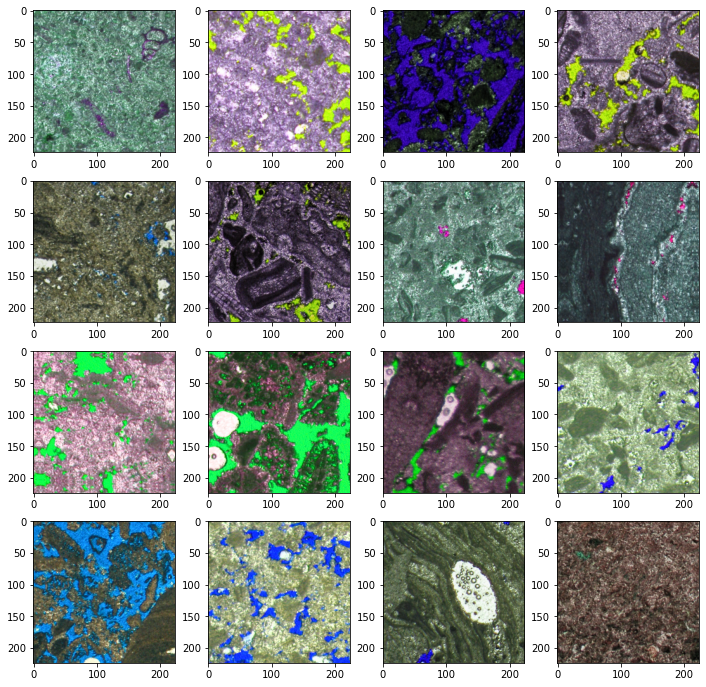

In [7]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(360, always_apply=True),
            A.RandomCrop(width=512, height=512),
            A.ElasticTransform(sigma=25, alpha_affine=25),
            A.GaussNoise(),
            A.HueSaturationValue(sat_shift_limit=0, val_shift_limit=50, hue_shift_limit=255, always_apply=True),
            A.Resize(width=224, height=224),
            A.Normalize(mean=mean, std=std)
]),
    'val': A.Compose([
    A.RandomCrop(width=512, height=512),
    A.Resize(width=224, height=224),
    A.Normalize(mean=mean, std=std),
    ])
}

train_dataset = ThinSectionDataset(torch.from_numpy(X_train_np), torch.from_numpy(y_train_np), class_names, transform=data_transforms['train'])
val_dataset = ThinSectionDataset(torch.from_numpy(X_val_np), torch.from_numpy(y_val_np), class_names, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

for dat, _ in train_loader:
    break

fig, axarr = plt.subplots(4, 4, figsize=(12, 12))
for ax, im in zip(axarr.flatten(), dat.numpy()):
    im = im.transpose(1, 2, 0)*std+mean
    ax.imshow(im)
plt.show()

In [8]:
model = models.vgg11(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(25088, 1024, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 256, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Linear(256, len(class_names), bias=True))

model = model.to(device)

if use_weighted_loss:
    _, class_frequency = np.unique(pore_type_train, return_counts=True)
    class_frequency = class_frequency/np.sum(class_frequency)

    weights = torch.from_numpy(1./class_frequency)

criterion = nn.CrossEntropyLoss(weight=weights.float().to(device) if use_weighted_loss else None)

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.classifier.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

In [ ]:
best_f1 = 0.0
sgd_steps = 0
initial = True
with tqdm(total=max_steps+1) as pbar:
    while sgd_steps < max_steps:
        sgd_steps, epoch_train_loss, epoch_train_f1 = train(sgd_steps, model, criterion, optimizer, train_loader, train_step_writer, device=device)

        train_step_writer.add_scalar("epoch_f1", global_step=sgd_steps, scalar_value=epoch_train_f1)
        train_step_writer.add_scalar("epoch_loss", global_step=sgd_steps, scalar_value=epoch_train_loss)
        train_step_writer.add_scalar("learning_rate", global_step=sgd_steps, scalar_value=get_lr(optimizer))
        pbar.set_description("Training Loss: {0:.2f}, Training F1: {1:.2f}, Best Val F1: {2:.2f}".format(epoch_train_loss, epoch_train_f1, best_f1))
        pbar.update(1)

        if sgd_steps % validate_every == 0 or initial:
            epoch_val_loss, epoch_val_f1, predictions = validate(model, criterion, val_loader, device="cuda", return_predictions=True)
            val_step_writer.add_scalar("epoch_f1", global_step=sgd_steps, scalar_value=epoch_val_f1)
            val_step_writer.add_scalar("f1_score", global_step=sgd_steps, scalar_value=epoch_val_f1)
            val_step_writer.add_scalar("epoch_loss", global_step=sgd_steps, scalar_value=epoch_val_loss)
            val_step_writer.add_scalar("loss", global_step=sgd_steps, scalar_value=epoch_val_loss)
            initial = False

            save_checkpoint(sgd_steps, model, optimizer, os.path.join(path, "checkpoints"), is_best=epoch_val_f1 > best_f1)
            if epoch_val_f1 > best_f1:
                best_f1 = epoch_val_f1

Training Loss: 1.54, Training F1: 0.46, Best Val F1: 0.17:   0%|          | 20/5001 [01:24<5:02:25,  3.64s/it]